In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import torch
import matplotlib
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import torchvision.transforms as transforms

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/matplotlib/font_manager.py:229: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [2]:
# Obrazok 28x28 ma spolu 784 px a tie budu vstupnou vrstvou (784 neuronov)
# Prvy skryty layer 128
# Druhy skryty layer 64
# na vystupe 10 neuronov (od 0-9)


In [3]:
trainset = datasets.MNIST("neuronove_siete_projekt",download=True,train=True)

In [4]:
testset = datasets.MNIST("neuronove_siete_projekt",download=True,train=False)

In [5]:
print("trainset {}".format(len(trainset)))
print("testset {}".format(len(testset)))

trainset 60000
testset 10000


In [6]:
print(trainset[0])

(<PIL.Image.Image image mode=L size=28x28 at 0x7F1C5FEB3AC8>, 5)


In [7]:
trainset[0][0]

In [8]:
img = trainset[0][0]
img_data=img.getdata()
print("min: {}".format(min(img_data)))
print("max: {}".format(max(img_data)))

min: 0
max: 255


In [9]:
# trieda obrazku je nieco ine ako matica a preto ju treba transformovat
#transforms = transforms.Compose([
#    #konvertujem obrazok na Tensor
#    transforms.ToTensor(),
# ])


In [10]:
# prevediem hodnoty z 0-255 na hodnoty od 0-1
# trainset = datasets.MNIST("neuronove_siete_projekt",download=True,train=True,transform=transforms)
# trainset[0][0]

In [11]:
# normalizujem si to a prevediem na interval -1až1
#konvertujem obrazok na Tensor
#mame šedé obrázky, tym padom nepotrebujem v poliach udavat RGB
transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5]),
    transforms.Lambda(lambda x: x.double())
])
testset = datasets.MNIST("neuronove_siete_projekt",download=True,train=False,transform=transforms)
trainset = datasets.MNIST("neuronove_siete_projekt",download=True,train=True,transform=transforms)
trainset[0][0]

tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1

In [12]:
# zmenili sme typ dat na standardny float64
trainset[0][0].dtype

torch.float64

In [13]:
# teraz potrebujem dataloader, pretoze keby chcem do premennej nacitat velke mnozstvo dat, zjedlo by to privela pamate
# data musim nasekat na tzv batches
# data si zamiesam 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,shuffle=True)

In [14]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
len(images)

64

In [15]:
# dimenzia matice je 64, potom je tam nejaka jednorozmerna blbost a 28x28 obrazky
#images.shape

In [16]:
# zbytocne dimenzie si vymazem cez squeeze
images.squeeze().shape

torch.Size([64, 28, 28])

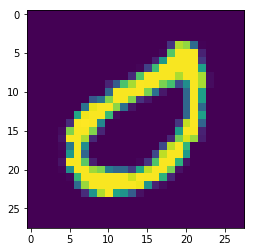

In [17]:
plt.imshow(images[0].squeeze())

In [18]:
# zobrazim si viac obrazkov
def show_images(images, labels, rows,cols):
    fig, axes = plt.subplots(rows, cols , figsize=(cols , rows))
    #vsetky podgrafy su teraz ulozene v tejto premennej
    #tato premenna je dvojrozmerne pole, ktore obsahuje spolu 6x10 podobrazkov
    for idx in range(0,rows*cols):
        ridx = idx//cols #celociselne delenie
        cidx = idx % cols
    
        ax = axes[ridx, cidx]
        ax.imshow(images[idx].squeeze())
        ax.set_title("{}".format(labels[idx]))
        ax.axis("off")
    plt.show()
    return fig
    
        

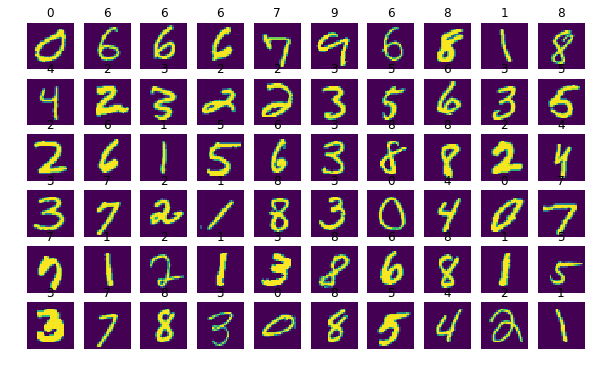

In [19]:
fig = show_images(images,labels, rows=6, cols=10)

In [20]:
# aktualne ale mam k cislu priradeny label. To nechcem, pretoze ja chcem mat na vystupe pravdepodobnosť od 0-9
x = np.zeros(10)
print(x)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [21]:
x[0]=1.0
print(x)

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [22]:
# vytvorim si funkciu, ktora mi tieto labels zmeni na vektory
def conv_to_vectors(labels):
    #na zaciatok si vytvorim docasne pole new_labels a bude to prazdne pole
    new_labels = []
    for label in labels:
        x = np.zeros(10)
        x[label]=1.0
        new_labels.append(x)
    new_labels=torch.from_numpy(np.vstack(new_labels))
    return new_labels

In [23]:
labels = conv_to_vectors(labels)
labels[3]

tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=torch.float64)

In [24]:
# kniznica obsahuje vela funkcii pre neuronove siete
import torch.nn as nn

In [25]:
INPUT_SIZE = 28*28
HIDDEN1_SIZE = 128
HIDDEN2_SIZE = 64
OUTPUT_SIZE = 10

In [26]:
# vytvorim si triedu, ktora bude dedit z nn.Module
# ked dedime z tejto triedy musime menit iba zopar funkcii a to konstruktor a funkciu forward
class DigiNet(nn.Module):
    def __init__(self):
            # musim zavolat originalny konstruktor
            super(DigiNet, self).__init__()
            # vytvorim prvu vrstvu. Linear trieda reprezentuje linearnu transformaciu - pocitanie hodnoty neuronu (vahy x hodnoty neuronu + bias)
            # ibaze v tomto pripade to reprezentuje celu jednu vrstvu. nn.Linear reprezentuje prechod medzi prvou a druhou vrstvou. 
            # Tato trieda v sebe obsahuje aj vahy, aj bias a vie pocitat hodnoty tych nasledovnych neuronov, cize takto je to zaobalene do tej jednej triedy.
            # Spravim to pre prvy, druhy a treti prechod a tak ziskam tri prechody medzi tymito vrstvami
            # vsetky linearne transformacie sa mi ulozia do triedy self, cize ked vytvorim instanciu DigiNet, budem mat ulozene tieto jednotlive prechody
            self.input_layer_weights=nn.Linear(INPUT_SIZE, HIDDEN1_SIZE)
            self.hidden_layer1_weights=nn.Linear(HIDDEN1_SIZE, HIDDEN2_SIZE)
            self.hidden_layer2_weights=nn.Linear(HIDDEN2_SIZE, OUTPUT_SIZE)
            
            # nepouzijem funkiu sigmoid ale pouzijem relu lebo je menej vypoctovo narocna a presnejsia pri viacvrstvovych sietach
            # pre mensiu hodnotu ako 0 vráti 0 a pre vacsiu vrati tu danu hodnotu
            self.act1=nn.ReLU()
            self.act2=nn.ReLU()
            # softmax vytvori pravdepodobnostnu distribuciu
            # zabezpecuje ze pravdepodobnost 100 % sa rozdeli medzi cisla
            self.act3=nn.Softmax(dim=1)
            
            # tak ako sme prevadzali obrazky na float64, musime to urobit aj s modelom
            self.double()
            
    def forward(self,x):
            x = self.input_layer_weights(x)
            x = self.act1(x)
            
            x = self.hidden_layer1_weights(x)
            x = self.act2(x)
            
            x = self.hidden_layer2_weights(x)
            x = self.act3(x)
            
            return x
                

In [27]:
#instancia neuronovej siete
model = DigiNet()

In [28]:
#obrazky mam sice 28x28 ale vstup je jednorozmerny vektor 768 cize potrebujem reshape
test = np.zeros((3,4))
print("pred reshapom: ",test)
test = test.reshape(1,12)
print("po reshape: ",test)

pred reshapom:  [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
po reshape:  [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [29]:
# view je to iste co reshape ale je to lepsie pretoze nekopiruje celu maticu len meni nahlad na data a teda neplytvam pamatou
images = images.view(images.shape[0],-1)
images.shape

torch.Size([64, 784])

In [30]:
# mohla by som zavolat aj forward.shape ale takto je to lepsie lebo taketo volanie robi na pozadi este aj ine operacie
predikcie= model(images)

In [31]:
# pre kazde cislo nejaka pravdepodobnost. Momentalne to nie je nic zmysluplne, vahy su nahodne inicializovane
predikcie[0]

tensor([0.0862, 0.1103, 0.1078, 0.1024, 0.0915, 0.0867, 0.1039, 0.0970, 0.1156,
        0.0986], dtype=torch.float64, grad_fn=<SelectBackward>)

In [32]:
# overim si, ci vsetky vahy davaju dokopy jednotku (100%)
print(predikcie[0].sum())
print(predikcie[1].sum())
print(predikcie[2].sum())

tensor(1., dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1., dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1., dtype=torch.float64, grad_fn=<SumBackward0>)


In [33]:
# idem pocitat mean square error
mse = nn.MSELoss()
#argumentmi su predikcie a ocakavane vystupy
loss = mse(predikcie, labels)
print(loss)

tensor(0.0895, dtype=torch.float64, grad_fn=<MseLossBackward>)


In [34]:
weights = model.parameters()
print(list(weights))

[Parameter containing:
tensor([[ 0.0278, -0.0323,  0.0261,  ...,  0.0148,  0.0294,  0.0331],
        [ 0.0036,  0.0074, -0.0014,  ...,  0.0127, -0.0001, -0.0108],
        [ 0.0230,  0.0196, -0.0264,  ...,  0.0022,  0.0087,  0.0003],
        ...,
        [-0.0107, -0.0041,  0.0285,  ...,  0.0075, -0.0330,  0.0050],
        [-0.0312,  0.0131,  0.0332,  ..., -0.0088, -0.0124,  0.0337],
        [-0.0005,  0.0330, -0.0184,  ...,  0.0305, -0.0194,  0.0028]],
       dtype=torch.float64, requires_grad=True), Parameter containing:
tensor([-2.7807e-02,  1.0722e-02,  1.1054e-02,  2.1791e-02,  3.1268e-02,
        -2.3684e-02,  1.6794e-02,  8.0343e-03,  2.3495e-02, -2.7265e-02,
         2.2013e-02,  1.7855e-02, -2.7753e-02,  2.7518e-02, -6.6619e-03,
        -4.7406e-03, -3.0784e-02, -2.4805e-02, -2.1899e-02,  6.9085e-03,
        -1.9627e-02, -1.7748e-02,  1.5134e-02,  3.1862e-02, -8.7659e-03,
         7.3339e-03, -3.5218e-02,  9.4094e-03,  1.1924e-02,  1.8005e-02,
         2.9742e-02, -1.1868e-02, 

In [35]:
# idem pocitat gradient tychto vah 
# gradient pripocitam k danej vahe v malych epochach
# pouzijem algoritmus backpropagation lebo zapisat tieto vsetky vahy by bolo tazke
# pre posledny layer viem povedat, ake zmeny by sa mali udiat, aby sme dostali lepsie vysledky.
# niektore zmeny treba posunut hore a niektore dolu
loss.backward()

In [36]:
#vypocty nerobime pre kazde cislo lebo by to bolo vypoctovo narocne a kvoli tomu sme pouzivali batches

In [37]:
from torch import optim

In [38]:
#moj aktualny shape
print (images.shape)

torch.Size([64, 784])


In [39]:
def train_model(model, epochs=15, lr=0.0035, momentum=0.7):
    sgd = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    mse = nn.MSELoss()
    for epoch in range(epochs):
        _loss = 0
        for images, labels in trainloader:
            images = images.view(images.shape[0], -1)
            sgd.zero_grad()
            preds = model(images)
            labels = conv_to_vectors(labels)
            loss = mse(preds, labels)
            loss.backward()
        
            # teraz cukneme tie váhy správnym smerom
            sgd.step()
            _loss += loss.item()
        else:
            print("Epoch {} - training loss: {}".format(
                epoch, _loss/len(trainloader)))
    return model

In [40]:
model = train_model(model)
#mozem vidiet ze chyba sa mi postupne zmensila

Epoch 0 - training loss: 0.0897172195630383
Epoch 1 - training loss: 0.08897925747803637
Epoch 2 - training loss: 0.0880435361500126
Epoch 3 - training loss: 0.08662505137767675
Epoch 4 - training loss: 0.08429185518842133
Epoch 5 - training loss: 0.08079544386153348
Epoch 6 - training loss: 0.07630975020100998
Epoch 7 - training loss: 0.0707740323440423
Epoch 8 - training loss: 0.06461021037300456
Epoch 9 - training loss: 0.058224250274032094
Epoch 10 - training loss: 0.05150711639961268
Epoch 11 - training loss: 0.044861278652043285
Epoch 12 - training loss: 0.038878750668825894
Epoch 13 - training loss: 0.034001383706224214
Epoch 14 - training loss: 0.03026320634449633


In [41]:
preds = model(images)

In [42]:
preds[0]

tensor([9.2932e-01, 2.1691e-05, 1.2556e-03, 4.1361e-03, 4.7170e-04, 5.9655e-02,
        1.2020e-03, 2.1725e-03, 1.5706e-03, 1.9905e-04], dtype=torch.float64,
       grad_fn=<SelectBackward>)

In [43]:
#vrati index najvacsej pravdepodobnosti tohto desat clenneho vektoru
preds[0].argmax()

tensor(0)

In [44]:
"{:%}".format(0.3587)

'35.870000%'

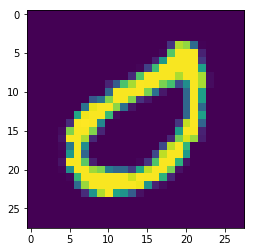

In [45]:
plt.imshow(images[0].view(28,28))
plt.show()

tensor(8)


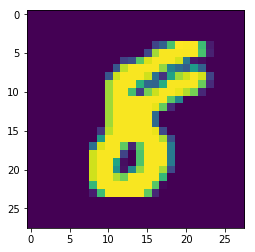

In [46]:
preds[7]
print(preds[7].argmax())
plt.imshow(images[7].view(28,28))
plt.show()

In [47]:
# teraz idem vyhodnotit ci je siet dobra alebo zla, kde ma nedostatky
# siet som trenovala na datasete MNIST. Ten obsahuje 60k trenovacich a 10k testovacich vzoriek
# ked sme robili gradient descent pri linearnej regresii, spravili sme graf, pri ktorom sme videli ako  chyba postupne klesala
# upravim si teda funkciu ucenia tak, ze tam pridam pole chyb a v else vetve vypocitam priemernu chybu
def train_model(model, epochs=15, lr=0.0035, momentum=0.7):
    sgd = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    mse = nn.MSELoss()
    losses = []
    for epoch in range(epochs):
        _loss = 0
        for images, labels in trainloader:
            images = images.view(images.shape[0], -1)
            sgd.zero_grad()
            preds = model(images)
            labels = conv_to_vectors(labels)
            loss = mse(preds, labels)
            loss.backward()
        
            # teraz cukneme tie váhy správnym smerom
            sgd.step()
            _loss += loss.item()
        else:
            avg_loss=_loss/len(trainloader)
            losses.append(avg_loss)
            print("Epoch {} - training loss: {}".format(
                epoch, _loss/len(trainloader)))
    return model, losses


In [48]:
def plot_loss(losses):
        fig = plt.figure()
        plt.plot(losses,color="g")
        
        plt.ylim(bottom=0,top=0.1)
        plt.xlabel("epocha")
        plt.ylabel("loss")
        plt.show()
        return fig

Epoch 0 - training loss: 0.09021712774732774
Epoch 1 - training loss: 0.09001020232171551
Epoch 2 - training loss: 0.08980768798305828
Epoch 3 - training loss: 0.08960316167190825
Epoch 4 - training loss: 0.08939771574495242
Epoch 5 - training loss: 0.08918999335119582
Epoch 6 - training loss: 0.08897783798716372
Epoch 7 - training loss: 0.08875779898963902
Epoch 8 - training loss: 0.0885229121583072
Epoch 9 - training loss: 0.08826936581804581
Epoch 10 - training loss: 0.0879916999826293
Epoch 11 - training loss: 0.08768284985017195
Epoch 12 - training loss: 0.08733819328764961
Epoch 13 - training loss: 0.08695151117621294
Epoch 14 - training loss: 0.08651949116393194
Epoch 15 - training loss: 0.0860312313593733
Epoch 16 - training loss: 0.08547479302232605
Epoch 17 - training loss: 0.0848318978560915
Epoch 18 - training loss: 0.08408092027243146
Epoch 19 - training loss: 0.08320738822341826
Epoch 20 - training loss: 0.08219025786395065
Epoch 21 - training loss: 0.0810151015111286
Epo

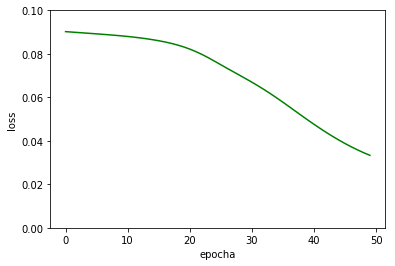

In [49]:
model = DigiNet()
model,losses=train_model(model, epochs=50, lr=0.001,momentum=0.7)
fig = plot_loss(losses)

In [54]:

#nejdem pocitat mean squared error ale rozdelim si to na spravne a nespravne predikcie
def validate_model(model, testset):
    correct_count, all_count = 0,0
    wrong_predictions = []
     #prejdem cez vsetkych 10k prikladov
    for image, label in testset:
        with torch.no_grad():
            pred = model(image.view(1,784))[0]
        pred_label = pred.argmax()
        #ak sa predikcia rovna labelu je to dobre
        if pred_label == label:
              #jednoducho zvysim correct_count
            correct_count += 1
        else:
            wrong_predictions.append((image, label, pred_label))
        all_count += 1
    return all_count, correct_count/all_count, wrong_predictions

In [60]:
total, accuracy, wp = validate(model,testset)
print("testovanych obrazkov:{}".format(total))
print("accuracy:{:.2%}".format(accuracy))

testovanych obrazkov:10000
accuracy:84.36%


Epoch 0 - training loss: 0.08973382421754224
Epoch 1 - training loss: 0.08903211514207635
Epoch 2 - training loss: 0.08819648140647016
Epoch 3 - training loss: 0.08708204359787527
Epoch 4 - training loss: 0.08536471444995422
Epoch 5 - training loss: 0.08261153545980039
Epoch 6 - training loss: 0.07872842520740837
Epoch 7 - training loss: 0.07414223105267052
Epoch 8 - training loss: 0.06862339248108927
Epoch 9 - training loss: 0.062368731840846195
Epoch 10 - training loss: 0.056186519352635245
Epoch 11 - training loss: 0.050504031837217696
Epoch 12 - training loss: 0.04525542555488522
Epoch 13 - training loss: 0.04045895850812412
Epoch 14 - training loss: 0.03626241516929863
Epoch 15 - training loss: 0.03278030614940626
Epoch 16 - training loss: 0.029930399331386918
Epoch 17 - training loss: 0.027628154428713046
Epoch 18 - training loss: 0.025767528205628956
Epoch 19 - training loss: 0.024244589605843275
Epoch 20 - training loss: 0.022993367055958964
Epoch 21 - training loss: 0.02196193

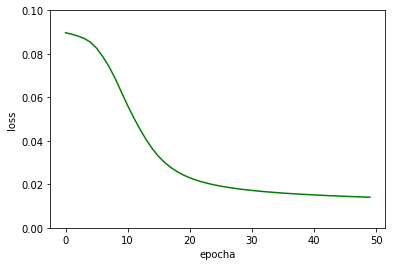

testovanych obrazkov:10000
accuracy:91.56%


In [62]:
model = DigiNet()
model,losses=train_model(model, epochs=50, lr=0.003,momentum=0.7)
fig = plot_loss(losses)
total, accuracy, wp = validate(model,testset)
print("testovanych obrazkov:{}".format(total))
print("accuracy:{:.2%}".format(accuracy))

Epoch 0 - training loss: 0.05726929301735205
Epoch 1 - training loss: 0.017969517543090358
Epoch 2 - training loss: 0.01442445099396489
Epoch 3 - training loss: 0.013048275232573858
Epoch 4 - training loss: 0.012097056496096343
Epoch 5 - training loss: 0.011347201435134378
Epoch 6 - training loss: 0.01061216527397702
Epoch 7 - training loss: 0.00998092204104805
Epoch 8 - training loss: 0.00931814193387358
Epoch 9 - training loss: 0.008736013487126937
Epoch 10 - training loss: 0.008159849022351036
Epoch 11 - training loss: 0.0076912287642622755
Epoch 12 - training loss: 0.007230083757082283
Epoch 13 - training loss: 0.006811526188383504
Epoch 14 - training loss: 0.006443828255410466
Epoch 15 - training loss: 0.006091862818929025
Epoch 16 - training loss: 0.005771397796604241
Epoch 17 - training loss: 0.005528644619145985
Epoch 18 - training loss: 0.005256104197973606
Epoch 19 - training loss: 0.004997441418016136
Epoch 20 - training loss: 0.004799291257298679
Epoch 21 - training loss: 0

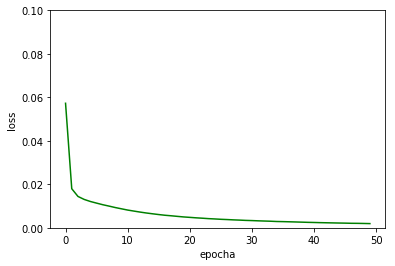

testovanych obrazkov:10000
accuracy:97.45%


In [89]:
model = DigiNet()
model,losses=train_model(model, epochs=50, lr=0.06,momentum=0.7)
fig = plot_loss(losses)
total, accuracy, wp = validate(model,testset)
print("testovanych obrazkov:{}".format(total))
print("accuracy:{:.2%}".format(accuracy))

Epoch 0 - training loss: 0.08925577000540645
Epoch 1 - training loss: 0.08693415831568162
Epoch 2 - training loss: 0.0816639434540763
Epoch 3 - training loss: 0.07110814930058935
Epoch 4 - training loss: 0.05810490976647719
Epoch 5 - training loss: 0.04564336685869384
Epoch 6 - training loss: 0.03596307189660336
Epoch 7 - training loss: 0.028821376979271084
Epoch 8 - training loss: 0.024168141201502038
Epoch 9 - training loss: 0.021370650980031547
Epoch 10 - training loss: 0.019616735285530686
Epoch 11 - training loss: 0.018442028710959495
Epoch 12 - training loss: 0.017576538674740166
Epoch 13 - training loss: 0.016901843265137988
Epoch 14 - training loss: 0.016370327303383465
Epoch 15 - training loss: 0.015913783937010692
Epoch 16 - training loss: 0.015536972430739107
Epoch 17 - training loss: 0.015196353858993894
Epoch 18 - training loss: 0.01489255380270673
Epoch 19 - training loss: 0.014616830583092646
Epoch 20 - training loss: 0.014382315804878565
Epoch 21 - training loss: 0.0141

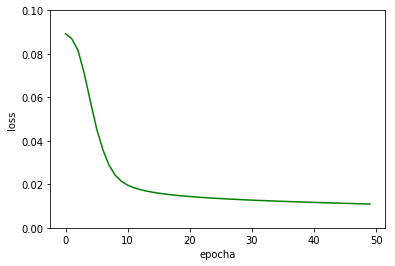

testovanych obrazkov:10000
accuracy:93.12%


In [63]:
model = DigiNet()
model,losses=train_model(model, epochs=50, lr=0.007,momentum=0.7)
fig = plot_loss(losses)
total, accuracy, wp = validate(model,testset)
print("testovanych obrazkov:{}".format(total))
print("accuracy:{:.2%}".format(accuracy))

In [87]:
import random
#zobrazim si zle predikcie
def wrong_preds(wp,rows=2,cols=5):
    #toto mi nasampluje 25 prvkov do premennej
    preds = random.sample(wp, rows*cols)
    fig,axes = plt.subplots(rows,cols,figsize=(cols,rows))
    # enumerate - iterujem cez prvok pola aj cez index
    for idx, (img,label, pred_label) in enumerate(preds):
        ridx =  idx // cols
        cidx = idx % cols
        
        ax = axes[ridx, cidx]
        ax.axis("off")
        ax.imshow(img.squeeze())
        ax.set_title("{}!={}".format(label,pred_label))
    plt.show()
    return fig
    

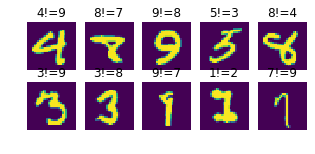

In [88]:
fig = wrong_preds(wp)